# 1-S2: 모델 저장/튜닝/설명

ML 모델의 실무 활용을 위한 3가지 핵심 기술을 학습합니다.

## 학습 목표
1. **모델 저장** - joblib로 학습된 모델 저장/로드
2. **하이퍼파라미터 튜닝** - Optuna로 최적의 설정값 찾기
3. **모델 설명** - SHAP으로 "왜 이렇게 예측했는가?" 설명

## 왜 이 3가지가 필요한가?

| 기술 | 없으면 생기는 문제 | 있으면 해결되는 것 |
|------|-------------------|-------------------|
| 모델 저장 | 매번 학습해야 함 (시간 낭비) | 한 번 학습 → 영구 사용 |
| 튜닝 | 기본값 사용 → 성능 아쉬움 | 최적 설정 → 성능 극대화 |
| 설명 | "왜?"에 답 못함 → 규제 위반 | 판단 근거 제시 → 신뢰 확보 |

In [6]:
# 패키지 설치 (필요시)
# !pip install -q optuna shap xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings('ignore')

print("패키지 임포트 완료")

패키지 임포트 완료


In [7]:
# 📚 Credit Card Fraud 데이터 로드 (전체 사용)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 로드 (전체 28만건)
df = pd.read_csv('../../../data/raw/creditcard.csv')

print(f"전체 데이터: {len(df):,}건")
print(f"사기 거래: {df['Class'].sum():,}건 ({df['Class'].mean():.2%})")

# 특성과 타겟 분리
feature_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                'V11', 'V12', 'V13', 'V14', 'Amount']
X = df[feature_cols]
y = df['Class']

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 불균형 가중치
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

print(f"Train: {len(X_train):,}건, Test: {len(X_test):,}건")
print(f"scale_pos_weight: {scale_pos_weight:.1f}")

전체 데이터: 284,807건
사기 거래: 492건 (0.17%)
Train: 227,845건, Test: 56,962건
scale_pos_weight: 577.3


---
## 1. 모델 저장 (joblib)

### 1-1. 왜 모델을 저장하는가?

**문제 상황:**
```python
# 매번 이렇게 해야 한다면?
model = XGBClassifier()
model.fit(X_train, y_train)  # 10분~1시간 소요
model.predict(new_data)
```

- 모델 학습은 오래 걸림 (수십 분 ~ 수 시간)
- 서버 재시작하면 모델 사라짐
- 다른 서버에서 같은 모델 쓰려면?

**해결책: 모델 저장**
```python
# 1. 학습 (한 번만)
model.fit(X_train, y_train)
joblib.dump(model, 'model.pkl')  # 저장

# 2. 사용 (매번)
model = joblib.load('model.pkl')  # 로드 (1초)
model.predict(new_data)
```

### 실제 사용 사례

| 상황 | 저장 없이 | 저장 있으면 |
|------|----------|------------|
| API 서버 시작 | 모델 학습 대기 (10분) | 모델 로드 (1초) |
| 여러 서버 배포 | 각 서버에서 학습 | 파일 복사만 |
| 모델 버전 관리 | 불가능 | model_v1.pkl, model_v2.pkl |
| 실험 재현 | 똑같은 모델 만들기 어려움 | 저장된 모델 로드 |

### 1-2. joblib vs pickle

| 비교 | pickle | joblib |
|------|--------|--------|
| Python 기본 | O (내장) | X (설치 필요) |
| NumPy 배열 | 느림 | **빠름** (최적화) |
| ML 모델 | 가능 | **권장** |
| 압축 | 없음 | 지원 (compress) |
| 확장자 | .pkl | **.joblib** (표준) |

**결론**: ML 모델은 NumPy 배열을 많이 포함하므로 **joblib + .joblib 확장자 사용**

In [8]:
# 📚 joblib 기본 사용법
import joblib
import os
from sklearn.ensemble import RandomForestClassifier

# 1. 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("1. 모델 학습 완료")

# 2. 모델 저장
# .joblib 확장자 사용 (현업 표준)
model_path = 'temp_model.joblib'
joblib.dump(model, model_path)
print(f"2. 모델 저장 완료: {model_path}")
print(f"   파일 크기: {os.path.getsize(model_path) / 1024:.1f} KB")

1. 모델 학습 완료
2. 모델 저장 완료: temp_model.joblib
   파일 크기: 2790.8 KB


In [9]:
# 📚 모델 로드 및 사용

# 3. 모델 로드 (새로운 세션이라고 가정)
loaded_model = joblib.load(model_path)
print("3. 모델 로드 완료")
print(f"   모델 타입: {type(loaded_model).__name__}")

# 4. 예측 (원래 모델과 동일하게 작동)
pred_original = model.predict(X_test)
pred_loaded = loaded_model.predict(X_test)

# 결과 비교
print(f"\n4. 예측 결과 비교:")
print(f"   원본 모델 예측: {pred_original[:10]}")
print(f"   로드 모델 예측: {pred_loaded[:10]}")
print(f"   동일 여부: {np.array_equal(pred_original, pred_loaded)}")

3. 모델 로드 완료
   모델 타입: RandomForestClassifier

4. 예측 결과 비교:
   원본 모델 예측: [0 0 0 0 0 0 0 0 0 0]
   로드 모델 예측: [0 0 0 0 0 0 0 0 0 0]
   동일 여부: True


In [10]:
# 📚 압축 저장 (용량이 큰 모델일 때)

# 압축 없이 저장
joblib.dump(model, 'model_no_compress.joblib')
size_no_compress = os.path.getsize('model_no_compress.joblib')

# 압축해서 저장 (compress=3 권장, 1~9 사이)
joblib.dump(model, 'model_compressed.joblib', compress=3)
size_compressed = os.path.getsize('model_compressed.joblib')

print("압축 비교:")
print(f"  압축 없음: {size_no_compress / 1024:.1f} KB")
print(f"  압축 적용: {size_compressed / 1024:.1f} KB")
print(f"  절약: {(1 - size_compressed/size_no_compress)*100:.1f}%")

# 임시 파일 정리
for f in ['temp_model.joblib', 'model_no_compress.joblib', 'model_compressed.joblib']:
    if os.path.exists(f):
        os.remove(f)
print("\n임시 파일 정리 완료")

압축 비교:
  압축 없음: 2790.8 KB
  압축 적용: 737.5 KB
  절약: 73.6%

임시 파일 정리 완료


### 1-3. 개발 → 프로덕션 흐름

**Phase별 모델 저장 방식**

```
Phase 1 (개발): joblib
    ↓
Phase 3 (프로덕션): joblib → ONNX → TensorRT → Triton
```

| 단계 | 도구 | 용도 | 속도 |
|------|------|------|------|
| **개발** | joblib | 빠른 저장/로드, 실험 | 기준 |
| 변환 | ONNX | 범용 포맷, 프레임워크 무관 | 2~3배 |
| 최적화 | TensorRT | LSTM GPU 최적화 | 5~10배 |
| 서빙 | Triton | 멀티모델 동시 서빙 | - |

**현업 표준 흐름:**
1. 개발/실험: `joblib.dump(model, 'model.joblib')`
2. 배포 준비: `onnxmltools.convert()` → ONNX 변환
3. DL 최적화: TensorRT로 LSTM 최적화
4. 서빙: Triton에서 XGBoost(ONNX) + LSTM(TensorRT) 동시 서빙

**지금은 joblib만 배우고, Phase 3에서 ONNX/TensorRT/Triton 학습 예정**

In [12]:
# 💻 실습 1
from xgboost import XGBClassifier
import joblib

# TODO 1: XGBClassifier 생성 및 학습
xgb_model = XGBClassifier(n_estimators=50, eval_metric='logloss', random_state=42)  # TODO: XGBClassifier(n_estimators=50, eval_metric='logloss', random_state=42)
# TODO: xgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
# TODO 2: 모델 저장 (.joblib 확장자)
# TODO: joblib.dump(xgb_model, 'xgb_model.joblib')
joblib.dump(xgb_model, 'xgb_model.joblib')
# TODO 3: 모델 로드
loaded_xgb = joblib.load('xgb_model.joblib')  # TODO: joblib.load('xgb_model.joblib')

# TODO 4: 예측
xgb_pred = loaded_xgb.predict(X_test)  # TODO: loaded_xgb.predict(X_test)

if xgb_pred is not None:
    print(f"예측 결과 (처음 10개): {xgb_pred[:10]}")

예측 결과 (처음 10개): [0 0 0 0 0 0 0 0 0 0]


In [13]:
# 실습 1 정답
from xgboost import XGBClassifier
import joblib

# 1. XGBClassifier 생성 및 학습
xgb_model = XGBClassifier(n_estimators=50, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 2. 모델 저장 (.joblib 확장자)
joblib.dump(xgb_model, 'xgb_model.joblib')

# 3. 모델 로드
loaded_xgb = joblib.load('xgb_model.joblib')

# 4. 예측
xgb_pred = loaded_xgb.predict(X_test)

print(f"예측 결과 (처음 10개): {xgb_pred[:10]}")

# 정리
if os.path.exists('xgb_model.joblib'):
    os.remove('xgb_model.joblib')

예측 결과 (처음 10개): [0 0 0 0 0 0 0 0 0 0]


In [ ]:
# 실습 1 정답
from xgboost import XGBClassifier
import joblib

# 1. XGBClassifier 생성 및 학습
xgb_model = XGBClassifier(n_estimators=50, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 2. 모델 저장
joblib.dump(xgb_model, 'xgb_model.pkl')

# 3. 모델 로드
loaded_xgb = joblib.load('xgb_model.pkl')

# 4. 예측
xgb_pred = loaded_xgb.predict(X_test)

print(f"예측 결과 (처음 10개): {xgb_pred[:10]}")

# 정리
if os.path.exists('xgb_model.pkl'):
    os.remove('xgb_model.pkl')

In [14]:
# 체크포인트 1
assert xgb_pred is not None, "예측 결과가 없습니다"
assert len(xgb_pred) == len(X_test), "예측 개수가 맞지 않습니다"

print("체크포인트 1 통과!")

체크포인트 1 통과!


---
## 2. 하이퍼파라미터 튜닝 (Optuna)

### 2-1. 하이퍼파라미터란?

**모델 파라미터 vs 하이퍼파라미터**

| 구분 | 파라미터 (Parameter) | 하이퍼파라미터 (Hyperparameter) |
|------|---------------------|-------------------------------|
| 정의 | 모델이 학습하는 값 | 우리가 설정하는 값 |
| 예시 | 트리의 분기 조건, 가중치 | 트리 개수, 트리 깊이 |
| 결정 시점 | 학습 중 자동 결정 | 학습 전 우리가 결정 |
| 변경 방법 | fit() 호출 | 모델 생성 시 지정 |

```python
# 하이퍼파라미터 = 우리가 정하는 설정값
model = XGBClassifier(
    n_estimators=100,     # 하이퍼파라미터: 트리 몇 개?
    max_depth=6,          # 하이퍼파라미터: 트리 깊이?
    learning_rate=0.1,    # 하이퍼파라미터: 학습 속도?
)

# 파라미터 = 모델이 학습하는 값 (우리가 안 건드림)
model.fit(X_train, y_train)  # 내부에서 최적의 분기 조건 학습
```

### 2-2. 왜 튜닝이 필요한가?

**기본값 vs 튜닝된 값**

```
XGBClassifier()                    → AUC 0.85
XGBClassifier(튜닝된 값)            → AUC 0.92
                                      +7% 향상!
```

**문제: 최적값을 어떻게 찾는가?**

- n_estimators: 50, 100, 200, 500...
- max_depth: 3, 4, 5, 6, 7, 8...
- learning_rate: 0.01, 0.05, 0.1, 0.2...

→ 조합이 너무 많음! 모든 조합을 시도하면 시간 오래 걸림

### 2-3. 튜닝 방법 비교

| 방법 | 설명 | 장점 | 단점 |
|------|------|------|------|
| **Grid Search** | 모든 조합 시도 | 빠짐없이 탐색 | 느림 |
| **Random Search** | 랜덤하게 시도 | 빠름 | 최적값 놓칠 수 있음 |
| **Optuna** | 똑똑하게 시도 | **빠름 + 정확** | 설치 필요 |

**Optuna의 핵심 아이디어:**
```
1회차: n_estimators=100, max_depth=5 → AUC 0.80
2회차: n_estimators=200, max_depth=5 → AUC 0.82  (n_estimators 늘리니 좋네)
3회차: n_estimators=300, max_depth=5 → AUC 0.83  (더 늘려보자)
4회차: n_estimators=300, max_depth=7 → AUC 0.85  (깊이도 늘려보자)
...
→ 이전 결과를 바탕으로 "좋은 방향"으로 탐색
```

In [15]:
# 📚 Grid Search 예시 (느린 방법)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

# 탐색할 파라미터 그리드
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
}

print(f"Grid Search: {2 * 3} = 6개 조합 시도")

# Grid Search 실행
start = time.time()
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,           # 3-fold cross validation
    scoring='roc_auc'
)
grid_search.fit(X_train, y_train)
elapsed = time.time() - start

print(f"\n소요 시간: {elapsed:.1f}초")
print(f"최적 파라미터: {grid_search.best_params_}")
print(f"최고 AUC: {grid_search.best_score_:.4f}")

Grid Search: 6 = 6개 조합 시도

소요 시간: 270.2초
최적 파라미터: {'max_depth': 7, 'n_estimators': 100}
최고 AUC: 0.9734


In [16]:
# 📚 Optuna 기본 사용법
import optuna
from sklearn.model_selection import cross_val_score

# Optuna 로그 숨기기
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """
    Optuna가 호출하는 목적 함수
    - trial: Optuna가 제안하는 하이퍼파라미터 조합
    - return: 최적화할 점수 (높을수록 좋음)
    """
    # 1. 하이퍼파라미터 범위 지정
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    
    # 2. 모델 생성
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    
    # 3. 교차 검증으로 성능 측정
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    
    return scores.mean()

# Optuna Study 생성 및 실행
print("Optuna 튜닝 시작...")
start = time.time()

study = optuna.create_study(direction='maximize')  # AUC 최대화
study.optimize(objective, n_trials=10)  # 10번 시도

elapsed = time.time() - start
print(f"\n소요 시간: {elapsed:.1f}초")
print(f"최적 파라미터: {study.best_params}")
print(f"최고 AUC: {study.best_value:.4f}")

Optuna 튜닝 시작...

소요 시간: 851.8초
최적 파라미터: {'n_estimators': 191, 'max_depth': 9}
최고 AUC: 0.9802


In [17]:
# 📚 Optuna 파라미터 타입

def show_optuna_types(trial):
    """
    Optuna에서 사용할 수 있는 파라미터 타입들
    """
    # 정수: suggest_int(이름, 최소, 최대)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    
    # 실수: suggest_float(이름, 최소, 최대)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    
    # 로그 스케일: suggest_float(..., log=True)
    # 0.001 ~ 1 사이를 균등하게 탐색
    reg_alpha = trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True)
    
    # 범주형: suggest_categorical(이름, [선택지])
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear'])
    
    return {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'reg_alpha': reg_alpha,
        'booster': booster
    }

print("Optuna 파라미터 타입:")
print("  suggest_int(): 정수 (트리 개수, 깊이 등)")
print("  suggest_float(): 실수 (학습률 등)")
print("  suggest_float(log=True): 로그 스케일 (정규화 강도 등)")
print("  suggest_categorical(): 범주형 (알고리즘 종류 등)")

Optuna 파라미터 타입:
  suggest_int(): 정수 (트리 개수, 깊이 등)
  suggest_float(): 실수 (학습률 등)
  suggest_float(log=True): 로그 스케일 (정규화 강도 등)
  suggest_categorical(): 범주형 (알고리즘 종류 등)


In [18]:
# 📚 XGBoost 튜닝 예시 (실전용)
from xgboost import XGBClassifier

def xgb_objective(trial):
    """XGBoost 하이퍼파라미터 튜닝"""
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    
    return scores.mean()

print("XGBoost Optuna 튜닝 시작...")
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=10, show_progress_bar=False)

print(f"\n최적 XGBoost 파라미터:")
for key, value in xgb_study.best_params.items():
    print(f"  {key}: {value}")
print(f"\n최고 AUC: {xgb_study.best_value:.4f}")

XGBoost Optuna 튜닝 시작...

최적 XGBoost 파라미터:
  n_estimators: 266
  max_depth: 4
  learning_rate: 0.02764470542836752
  subsample: 0.6091568127878483
  colsample_bytree: 0.7466530112122219

최고 AUC: 0.9831


### 💻 실습 2: Optuna로 튜닝

RandomForest의 `n_estimators`와 `max_depth`를 튜닝하세요.

In [19]:
# 💻 실습 2
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

optuna.logging.set_verbosity(optuna.logging.WARNING)

def rf_objective(trial):
    # TODO: n_estimators (50~200), max_depth (3~10) 범위 지정
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # TODO: trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)     # TODO: trial.suggest_int('max_depth', 3, 10)
    
    if n_estimators is None or max_depth is None:
        return 0
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

# TODO: Study 생성 및 실행
rf_study = optuna.create_study(direction='maximize')  # TODO: optuna.create_study(direction='maximize')
# TODO: rf_study.optimize(rf_objective, n_trials=10)
rf_study.optimize(rf_objective, n_trials=10)

if rf_study is not None:
    print(f"최적 파라미터: {rf_study.best_params}")
    print(f"최고 AUC: {rf_study.best_value:.4f}")

최적 파라미터: {'n_estimators': 138, 'max_depth': 8}
최고 AUC: 0.9792


In [ ]:
# 실습 2 정답
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

optuna.logging.set_verbosity(optuna.logging.WARNING)

def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=10)

print(f"최적 파라미터: {rf_study.best_params}")
print(f"최고 AUC: {rf_study.best_value:.4f}")

In [22]:
# 체크포인트 2
assert rf_study is not None, "Study가 생성되지 않았습니다"
assert rf_study.best_value > 0.5, "AUC가 0.5보다 커야 합니다"

print("체크포인트 2 통과!")

체크포인트 2 통과!


---
## 3. 모델 설명 (SHAP)

### 3-1. 왜 모델 설명이 필요한가?

#### 문제 상황

```
고객: "왜 제 거래가 차단됐나요?"
담당자: "AI가 사기로 판단했습니다."
고객: "왜요?"
담당자: "...모르겠습니다." ← 문제!
```

#### 금융 규제 요구사항

- **EU GDPR Article 22**: 자동화된 의사결정에 대한 설명 권리
- **한국 신용정보법**: AI 신용평가 결과에 대한 설명 의무
- **미국 ECOA**: 신용 거부 사유 고지 의무

**→ "왜?"에 답할 수 없으면 법적 문제 발생!**

#### SHAP으로 해결

```
고객: "왜 제 거래가 차단됐나요?"
담당자: "SHAP 분석 결과:
        - 평소보다 금액이 5배 높음 (+30%)
        - 새벽 3시 거래 (+25%)
        - 해외 결제 (+20%)
        이 3가지가 사기 확률을 높였습니다."
고객: "아, 해외여행 중이라 그래요."
담당자: "확인되었습니다. 차단 해제하겠습니다."
```

### 3-2. SHAP 원리 (간단히)

**SHAP = SHapley Additive exPlanations**

게임 이론의 Shapley Value를 ML에 적용:

```
기본 예측: 사기 확률 10% (평균)

이 거래의 특성 기여도:
  + amount 효과: +25%  (금액이 높아서 사기 확률 ↑)
  + hour 효과:   +15%  (새벽이라 사기 확률 ↑)
  + is_foreign:  +10%  (해외라 사기 확률 ↑)
  ─────────────────────
  최종 예측:     60%   (이 거래의 사기 확률)
```

**핵심: 각 특성이 예측에 얼마나 기여했는지 분해**

### 3-3. SHAP Explainer 종류

| Explainer | 대상 모델 | 속도 | 정확도 |
|-----------|----------|------|--------|
| **TreeExplainer** | 트리 모델 (XGBoost, RF) | 빠름 | 정확 |
| DeepExplainer | 딥러닝 (LSTM 등) | 보통 | 정확 |
| KernelExplainer | 모든 모델 | 느림 | 근사 |

**FDS 프로젝트:**
- XGBoost → TreeExplainer
- LSTM → DeepExplainer

In [20]:
# 📚 SHAP 기본 사용법
import shap

# 1. 모델 학습
model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
print("1. 모델 학습 완료")

# 2. SHAP Explainer 생성
explainer = shap.TreeExplainer(model)
print("2. TreeExplainer 생성 완료")

# 3. SHAP 값 계산
shap_values = explainer.shap_values(X_test)
print(f"3. SHAP 값 계산 완료")
print(f"   shape: {shap_values.shape}")
print(f"   의미: ({len(X_test)}개 샘플, {len(X.columns)}개 특성)")

1. 모델 학습 완료
2. TreeExplainer 생성 완료
3. SHAP 값 계산 완료
   shape: (56962, 15)
   의미: (56962개 샘플, 15개 특성)


In [23]:
# 📚 개별 예측 설명 (단일 거래)

# 첫 번째 테스트 샘플 분석
idx = 0
sample = X_test.iloc[idx]
sample_shap = shap_values[idx]

print("개별 거래 분석")
print("=" * 50)
print(f"\n거래 정보 (Credit Card 데이터):")
print(f"  Amount: ${sample['Amount']:,.2f}")
print(f"  V14: {sample['V14']:.4f}")  # V14가 사기 탐지에 중요한 특성

print(f"\n예측 결과:")
pred_proba = model.predict_proba(sample.values.reshape(1, -1))[0, 1]
print(f"  사기 확률: {pred_proba:.1%}")

print(f"\nSHAP 기여도 Top 5 (왜 이렇게 예측했나):")
# SHAP 값 기준 정렬
shap_sorted = sorted(zip(feature_cols, sample_shap), key=lambda x: abs(x[1]), reverse=True)
for name, value in shap_sorted[:5]:
    direction = "↑ 사기" if value > 0 else "↓ 정상"
    print(f"  {name}: {value:+.4f} {direction}")

print(f"\n  기본값(base): {explainer.expected_value:.4f}")
print(f"  최종 예측:    {explainer.expected_value + sum(sample_shap):.4f}")

개별 거래 분석

거래 정보 (Credit Card 데이터):
  Amount: $23.00
  V14: 0.2664

예측 결과:
  사기 확률: 0.0%

SHAP 기여도 Top 5 (왜 이렇게 예측했나):
  V4: -1.9703 ↓ 정상
  V5: -0.8218 ↓ 정상
  V10: -0.6863 ↓ 정상
  V3: -0.6823 ↓ 정상
  V2: -0.6576 ↓ 정상

  기본값(base): -9.6577
  최종 예측:    -14.0441


SHAP Summary Plot
- 각 점 = 하나의 샘플
- 색상 = 특성 값 (빨강=높음, 파랑=낮음)
- X축 = SHAP 값 (오른쪽=사기 확률 증가)



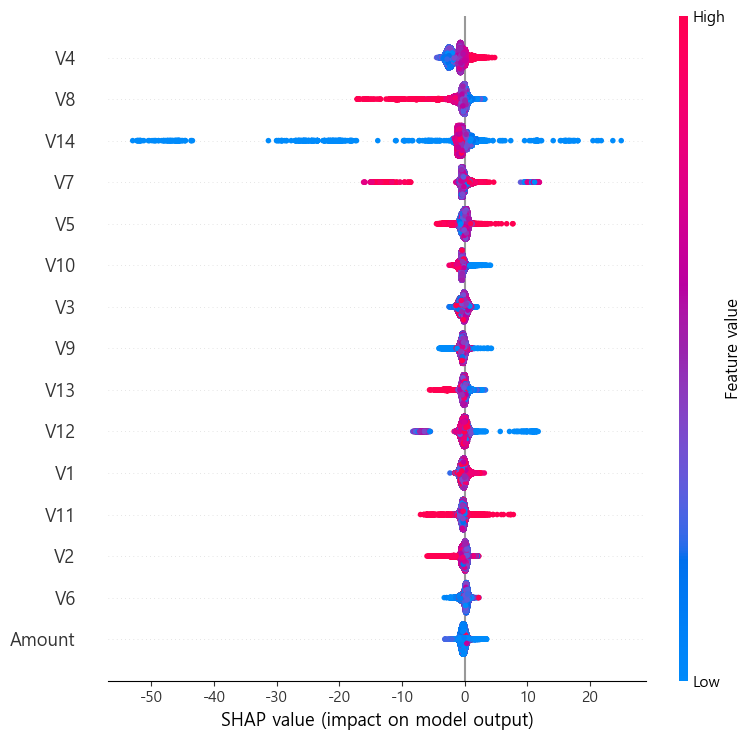

In [24]:
# 📚 SHAP Summary Plot (전체 특성 중요도)

print("SHAP Summary Plot")
print("- 각 점 = 하나의 샘플")
print("- 색상 = 특성 값 (빨강=높음, 파랑=낮음)")
print("- X축 = SHAP 값 (오른쪽=사기 확률 증가)")
print()

shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist(), show=True)

SHAP Bar Plot (평균 절대 SHAP 값)
- 높을수록 예측에 영향력 큰 특성



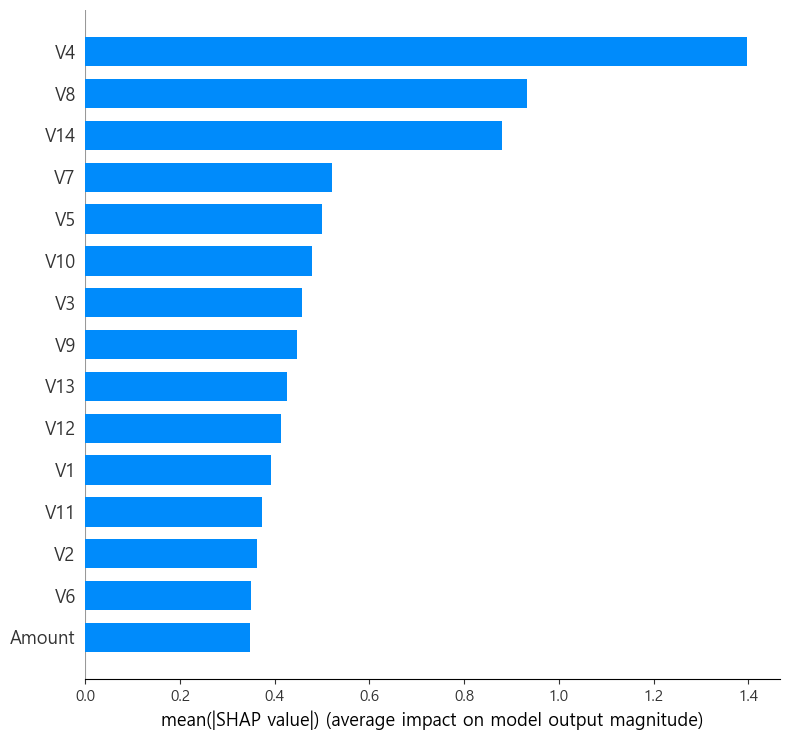

In [25]:
# 📚 SHAP Bar Plot (특성 중요도 순위)

print("SHAP Bar Plot (평균 절대 SHAP 값)")
print("- 높을수록 예측에 영향력 큰 특성")
print()

shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist(), plot_type="bar", show=True)

SHAP Force Plot (단일 거래)
- 빨간색: 사기 확률 높이는 요인
- 파란색: 사기 확률 낮추는 요인



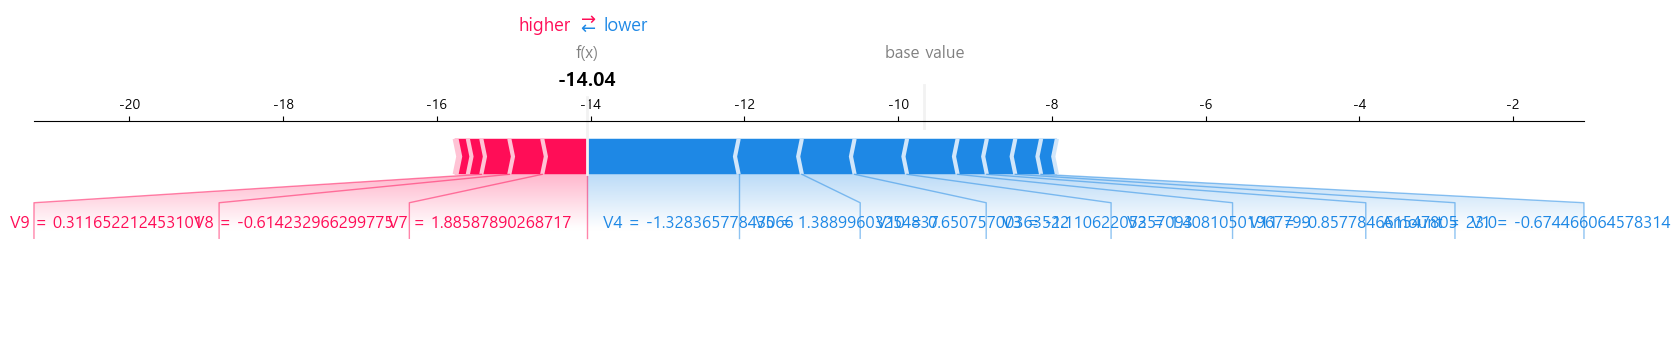

In [26]:
# 📚 SHAP Force Plot (단일 예측 시각화)

print("SHAP Force Plot (단일 거래)")
print("- 빨간색: 사기 확률 높이는 요인")
print("- 파란색: 사기 확률 낮추는 요인")
print()

# Matplotlib 기반 force plot
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0],
    matplotlib=True,
    show=True
)

SHAP Waterfall Plot
- 각 특성이 기본값에서 얼마나 변화시켰는지



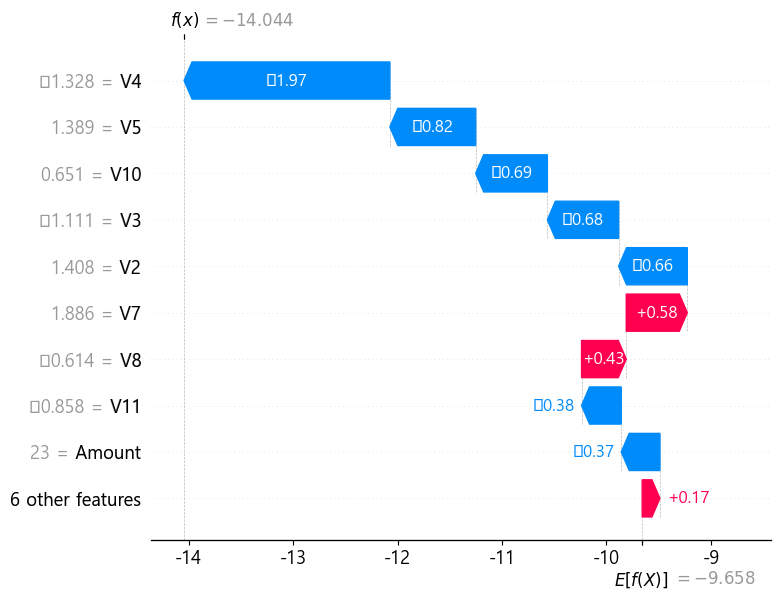

In [27]:
# 📚 SHAP Waterfall Plot (더 읽기 쉬운 버전)

print("SHAP Waterfall Plot")
print("- 각 특성이 기본값에서 얼마나 변화시켰는지")
print()

# Explanation 객체 생성
explanation = shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[0].values,
    feature_names=X.columns.tolist()
)

shap.waterfall_plot(explanation, show=True)

### 3-4. 실제 FDS에서 SHAP 활용

```python
# API 응답 예시 (실제 FDS에서는 해석 가능한 특성명 사용)
{
    "transaction_id": "TX123456",
    "prediction": "fraud",
    "fraud_probability": 0.85,
    "explanation": {
        "top_factors": [
            {"feature": "V14", "contribution": 0.35, "value": -5.2},
            {"feature": "V17", "contribution": 0.25, "value": -3.1},
            {"feature": "Amount", "contribution": 0.15, "value": 2500000}
        ],
        "message": "V14, V17 패턴이 비정상적이고 금액(250만원)이 높아 사기로 판단되었습니다."
    }
}
```

> **참고**: Credit Card 데이터는 PCA 변환되어 V1~V28로 익명화됨.
> 실제 FDS에서는 "거래금액", "거래시간", "해외결제 여부" 등 해석 가능한 특성 사용.

**활용 사례:**
1. 고객 문의 응대: "왜 차단됐나요?" → SHAP 결과로 설명
2. 모델 디버깅: 이상한 예측 → SHAP으로 원인 분석
3. 규제 보고: 감독기관에 모델 판단 근거 제출

### 💻 실습 3: SHAP 분석

XGBoost 모델의 SHAP 값을 계산하고, 가장 중요한 특성을 찾으세요.

In [29]:
# 💻 실습 3
import shap
from xgboost import XGBClassifier

# 모델 학습 (이미 위에서 했다면 생략 가능)
# model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
# model.fit(X_train, y_train)

# TODO 1: TreeExplainer 생성
explainer = shap.TreeExplainer(model)  # TODO: shap.TreeExplainer(model)

# TODO 2: SHAP 값 계산
shap_values = explainer.shap_values(X_test)  # TODO: explainer.shap_values(X_test)

# TODO 3: 평균 절대 SHAP 값으로 특성 중요도 계산
if shap_values is not None:
    mean_shap = np.abs(shap_values).mean(axis=0)  # TODO: np.abs(shap_values).mean(axis=0)
    
    if mean_shap is not None:
        print("특성 중요도 (평균 |SHAP|):")
        for name, importance in zip(X.columns, mean_shap):
            print(f"  {name}: {importance:.4f}")

특성 중요도 (평균 |SHAP|):
  V1: 0.3923
  V2: 0.3635
  V3: 0.4571
  V4: 1.3972
  V5: 0.5007
  V6: 0.3505
  V7: 0.5216
  V8: 0.9336
  V9: 0.4462
  V10: 0.4784
  V11: 0.3741
  V12: 0.4130
  V13: 0.4264
  V14: 0.8804
  Amount: 0.3484


In [30]:
# 실습 3 정답
import shap
from xgboost import XGBClassifier

# 모델 학습
model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 1. TreeExplainer 생성
explainer = shap.TreeExplainer(model)

# 2. SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# 3. 평균 절대 SHAP 값으로 특성 중요도 계산
mean_shap = np.abs(shap_values).mean(axis=0)

print("특성 중요도 (평균 |SHAP|):")
for name, importance in sorted(zip(X.columns, mean_shap), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {importance:.4f}")

특성 중요도 (평균 |SHAP|):
  V4: 1.3972
  V8: 0.9336
  V14: 0.8804
  V7: 0.5216
  V5: 0.5007
  V10: 0.4784
  V3: 0.4571
  V9: 0.4462
  V13: 0.4264
  V12: 0.4130
  V1: 0.3923
  V11: 0.3741
  V2: 0.3635
  V6: 0.3505
  Amount: 0.3484


In [31]:
# 체크포인트 3
assert explainer is not None, "Explainer가 생성되지 않았습니다"
assert shap_values is not None, "SHAP 값이 계산되지 않았습니다"
assert shap_values.shape == (len(X_test), len(X.columns)), "SHAP 값 shape이 맞지 않습니다"

print("체크포인트 3 통과!")

체크포인트 3 통과!


---
## 최종 체크포인트

In [ ]:
print("="*60)
print("  1-S2 완료: 모델 저장/튜닝/설명")
print("="*60)
print()
print("배운 것:")
print()
print("1. 모델 저장 (joblib)")
print("   - joblib.dump(): 모델 저장")
print("   - joblib.load(): 모델 로드")
print("   - 왜? 학습 시간 절약, 배포 용이")
print()
print("2. 하이퍼파라미터 튜닝 (Optuna)")
print("   - 하이퍼파라미터: 우리가 설정하는 값 (트리 개수, 깊이 등)")
print("   - Optuna: 이전 결과를 바탕으로 똑똑하게 탐색")
print("   - 왜? 기본값보다 성능 향상")
print()
print("3. 모델 설명 (SHAP)")
print("   - TreeExplainer: 트리 모델용 (XGBoost)")
print("   - SHAP 값: 각 특성의 예측 기여도")
print("   - 왜? 규제 준수, 고객 설명, 모델 디버깅")
print()
print("="*60)
print("다음: 1-S3 XGBoost 심화")
print("="*60)